In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from argparse import Namespace
import os
from pathlib import Path
from tqdm.notebook import trange, tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from score_sde.models.discriminator import Discriminator_small
from score_sde.models.ncsnpp_generator_adagn import NCSNpp

c:\Users\kirill-korolev\anaconda3\envs\kkorolev\Lib\site-packages\torch\utils\cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [3]:
def load_checkpoint(net, ckpt_path):
    ckpt = torch.load(ckpt_path)
    for key in list(ckpt.keys()):
        ckpt[key[7:]] = ckpt.pop(key)
    net.load_state_dict(ckpt)

device = "cuda:0"
#device = "cpu"
args = Namespace(seed=1024, resume=True, image_size=32, num_channels=3, centered=True, use_geometric=False, beta_min=0.1, beta_max=20.0, num_channels_dae=128, n_mlp=4, ch_mult=[1, 2, 2, 2], num_res_blocks=2, attn_resolutions=(16,), dropout=0.0, resamp_with_conv=True, conditional=True, fir=True, fir_kernel=[1, 3, 3, 1], skip_rescale=True, resblock_type='biggan', progressive='none', progressive_input='residual', progressive_combine='sum', embedding_type='positional', fourier_scale=16.0, not_use_tanh=False, exp='ddgan_stackmnist_exp1', dataset='stackmnist', nz=100, num_timesteps=4, z_emb_dim=256, t_emb_dim=256, batch_size=64, num_epoch=1800, ngf=64, lr_g=0.00016, lr_d=0.000125, beta1=0.5, beta2=0.9, no_lr_decay=False, use_ema=True, ema_decay=0.9999, r1_gamma=0.02, lazy_reg=15, save_content=True, save_content_every=100, save_ckpt_every=100, num_proc_node=1, num_process_per_node=1, node_rank=0, local_rank=0, master_address='127.0.0.1')
ckpt_path = Path("saved_info/dd_gan/cifar10/ddgan_cifar10_exp1")

netG = NCSNpp(args).to(device)
load_checkpoint(netG, ckpt_path / f"netG_1200.pth")
netG.eval()

netD = Discriminator_small(
    nc=2 * args.num_channels,
    ngf=args.ngf,
    t_emb_dim=args.t_emb_dim,
    act=nn.LeakyReLU(0.2),
).to(device)
netD.load_state_dict(torch.load(ckpt_path / f"netD_1400.pth"))
netD.eval()

print()

C:\Users\kirill-korolev\AppData\Local\Temp\ipykernel_8808\4118022648.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


C:\Users\kirill-korolev\AppData\Local\Temp\ipykernel_8808\4118022648.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netD.load_state_dict(torch.load(ckpt_path / f"netD_

In [4]:
from sampler.utils import Diffusion_Coefficients, Posterior_Coefficients, extract, get_sigma_schedule, q_sample_next
from sampler.rejection_sampling import RejectionSamplingProcessor

In [5]:
pos_coeff = Posterior_Coefficients(args, device)
coeff = Diffusion_Coefficients(args, device)
# dicts = []
# num_runs_range = torch.linspace(1, 500, 5)
# for n_runs in num_runs_range:
#     log_ratio_dict = RejectionSamplingProcessor.recalculate_log_ratio(pos_coeff, netG, netD, n_time=4, opt=args, device=device, n_runs=int(n_runs)).log_ratio_dict
#     dicts.append(log_ratio_dict)
#     print(n_runs)

In [6]:
# t = torch.arange(4).to(device)
# x_t = torch.arange(t.shape[0] * 8 * 8).reshape(-1, 8, 8).to(device)
# print(extract(coeff.a_s, t + 1, x_t.shape), extract(coeff.sigmas, t + 1, x_t.shape))

# sigmas = pos_coeff.betas**0.5
# a_s = torch.sqrt(1 - pos_coeff.betas)
# print(extract(a_s, t, x_t.shape), extract(sigmas, t, x_t.shape))

In [7]:
rs_processor = RejectionSamplingProcessor.recalculate_log_ratio(pos_coeff, netG, netD, n_time=4, opt=args, device=device, n_runs=1000)
log_ratio_dict = rs_processor.log_ratio_dict

with open("log_ratio_dict.pickle", "wb") as f:
    pickle.dump(log_ratio_dict, f)

# with open("dicts.pickle", "wb") as f:
#     pickle.dump(dicts, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
# plt.figure(figsize=(12, 4))
# for t in range(4):
#     plt.subplot(1, 4, t + 1)
#     print([torch.max(dicts[i][t]) for i in range(len(dicts))])
#     plt.plot(num_runs_range * args.batch_size, [torch.max(dicts[i][t]) for i in range(len(dicts))])
#     plt.xlabel("num samples")
#     plt.ylabel("max log ratio")
#     plt.title(f"t={t}")
# plt.tight_layout()

In [15]:
with open("log_ratio_dict.pickle", "rb") as f:
    log_ratio_dict = pickle.load(f)

rs_processor = RejectionSamplingProcessor(netD, log_ratio_dict, device, constant_quantile=0.95)

rs_processor.log_ratio_dict[0].shape, rs_processor.log_constant_dict

(torch.Size([64000]),
 {3: 1.0974624156951904, 2: 1.1558836698532104, 1: 1.1175920963287354, 0: 0})

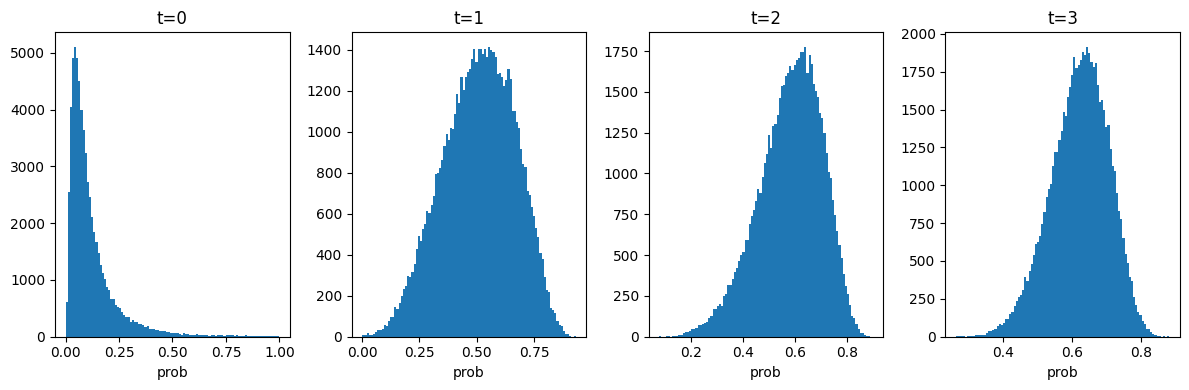

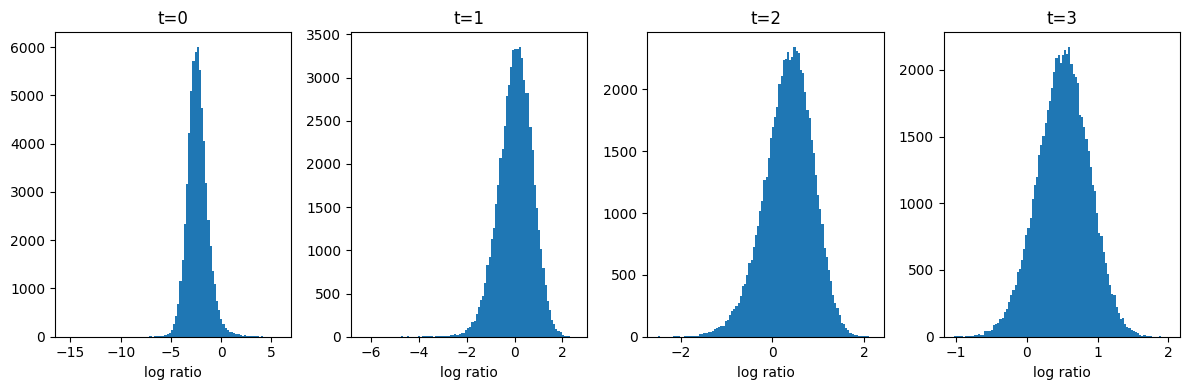

In [16]:
plt.figure(figsize=(12, 4))
for i in rs_processor.log_ratio_dict.keys():
    plt.subplot(1, len(rs_processor.log_ratio_dict.keys()), i + 1)
    plt.hist(torch.sigmoid(rs_processor.log_ratio_dict[i]).cpu(), bins=100)
    plt.title(f"t={i}")
    plt.xlabel("prob")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in rs_processor.log_ratio_dict.keys():
    plt.subplot(1, len(rs_processor.log_ratio_dict.keys()), i + 1)
    plt.hist(rs_processor.log_ratio_dict[i].cpu(), bins=100)
    plt.title(f"t={i}")
    plt.xlabel("log ratio")
plt.tight_layout()
plt.show()

$$
D^*(x) = \frac{1}{1 + \exp{(-F^*(x))}} = \frac{q(x)}{q(x)+p(x)}\\
F^*(x) = \log{\frac{D^*(x)}{1 - D^*(x)}} = \log{\frac{q(x)}{p(x)}}\\
$$

In [17]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
%matplotlib inline

def tensor_to_grid(image):
    image = image.add(1).mul(127.5).clamp(0, 255)
    return make_grid(image, nrow=int(np.sqrt(image.shape[0])), padding=0)

In [18]:
from sampler.rejection_sampling import rejection_sample, rejection_sample_reinit

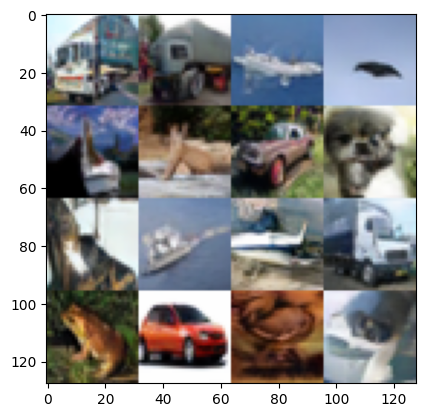

In [19]:
rs_processor = RejectionSamplingProcessor(netD, log_ratio_dict, device, constant_quantile=0.7)

x_t_1 = torch.randn(
    16, args.num_channels, args.image_size, args.image_size
).to(device)

args.reinit_steps = 4
args.reject_full_trajectory = False

try:
    #x_0 = rejection_sample(pos_coeff, netG, rs_processor, n_time=4, x_init=x_t_1, opt=args, reject_full_trajectory=True)
    x_0 = rejection_sample_reinit(pos_coeff, netG, rs_processor, n_time=4, x_init=x_t_1, opt=args)
    grid = tensor_to_grid(x_0)
    plt.imshow(grid.permute(1, 2, 0).to("cpu", torch.uint8).numpy())
    plt.show()
except Exception as exc:
    print("error", exc)

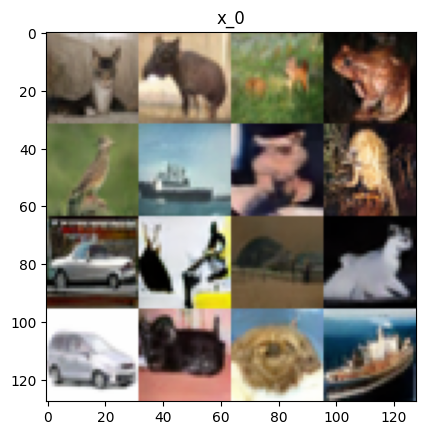

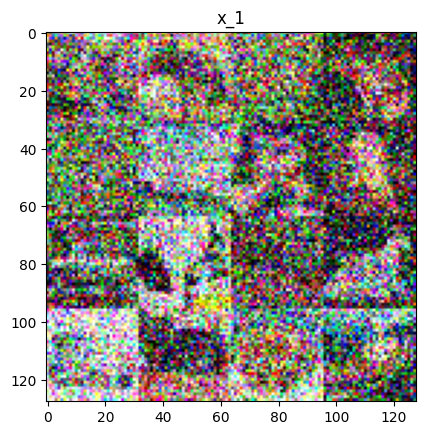

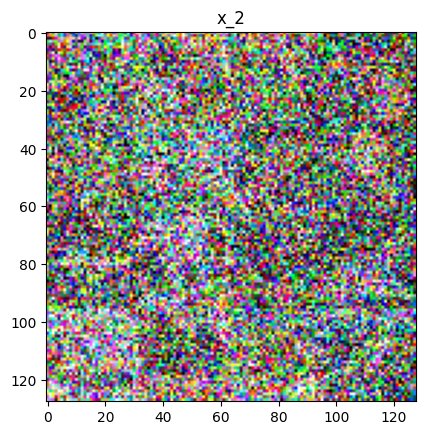

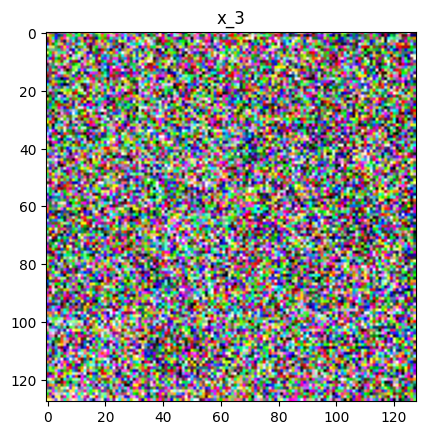

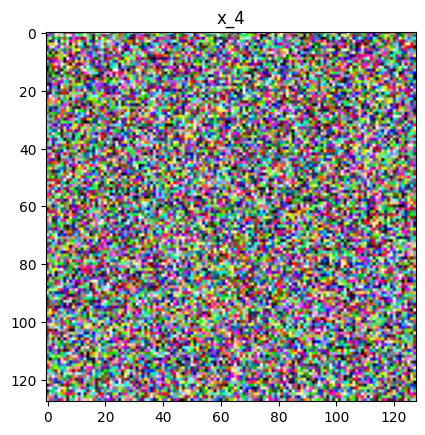

In [14]:
x_t = x_0
grid = tensor_to_grid(x_t)
plt.imshow(grid.permute(1, 2, 0).to("cpu", torch.uint8).numpy())
plt.title("x_0")
plt.show()
for i in range(4):
    t = i * torch.ones((x_0.shape[0]), dtype=torch.int64, device=x_0.device)
    x = q_sample_next(pos_coeff, x_t, t, t + 1)
    grid = tensor_to_grid(x)
    plt.imshow(grid.permute(1, 2, 0).to("cpu", torch.uint8).numpy())
    plt.title(f"x_{i+1}")
    plt.show()